In [1]:
# dependancies
import pandas as pd
from skbio import TreeNode
from io import StringIO
import re
from skbio.diversity import alpha_diversity
from scipy.stats import entropy
from scipy.stats import wilcoxon
from skbio.diversity import beta_diversity
from skbio.stats.distance import mantel
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
plt.rcParams['font.family'] = 'Arial'

In [2]:
# functions

def pretty_print_matrix(matrix):
    for row in matrix:
        print(" ".join(str(item).ljust(5) for item in row))

def make_count_matrix(data, numRows): 
    count_matrix = []  
    count_multiplier = 10000
    for i in range(numRows):
        row_values = data.iloc[i].tolist()
        rounded_row = [round(value * count_multiplier) for value in row_values]
        count_matrix.append(rounded_row)
    return count_matrix

### Data prep

In [4]:
# input is a count matrix (rows are samples) x (columns are unique species)
file_spp = "processed_data/spp_countMatrix.csv"
genus_spp = "processed_data/genus_countMatrix.csv"

# read in data
raw_spp = pd.read_csv(file_spp, sep=",", header=0)
raw_genus = pd.read_csv(genus_spp, sep=",", header=0)

# get all species and genus
all_OTUs_spp = raw_spp.columns.tolist()
all_OTUs_genus = raw_genus.columns.to_list()

# get count matrix dimensions
spp_numRows = len(raw_spp)
spp_numCols = len(all_OTUs_spp)
genus_numRows = len(raw_genus)
genus_numCols = len(all_OTUs_genus)

# prepare data
countmatrix_spp = make_count_matrix(raw_spp, spp_numRows)
countmatrix_genus = make_count_matrix(raw_genus, genus_numRows)

# ids
ids = ['Ground Truth', 
       'A SR16s', 'B SR16s', 'C SR16s', 'D SR16s', 'E SR16s', 'F SR16s', 
       'A LR16s ONT', 'B LR16s ONT', 'C LR16s ONT', 'D LR16s ONT', 'E LR16s ONT', 'F LR16s ONT', 
       'A LR16s KAPA', 'B LR16s KAPA', 'C LR16s KAPA', 'D LR16s KAPA', 'E LR16s KAPA', 'F LR16s KAPA', 
       'A SR shotgun', 'B SR shotgun', 'C SR shotgun', 'E SR shotgun', 'F SR shotgun', 
       'A LR shotgun', 'B LR shotgun', 'C LR shotgun', 'D LR shotgun', 'E LR shotgun', 'F LR shotgun']

In [5]:
pretty_print_matrix(countmatrix_spp)
# pretty_print_matrix(countmatrix_genus)

0     0     0     0     0     2222  0     1111  0     0     0     0     1111  0     0     0     0     1111  0     0     0     2222  0     1111  0     0     1111  0     0     0    
0     0     0     0     7986  0     446   0     0     596   0     0     0     0     65    0     0     0     0     0     453   0     0     0     0     0     0     0     0     454  
0     0     0     0     8442  0     465   0     0     472   3     0     0     0     27    0     0     0     0     0     168   0     25    0     0     0     0     0     0     398  
0     0     7     0     6772  0     396   0     0     1351  0     65    35    0     147   0     0     0     0     0     781   0     0     0     0     0     0     0     0     445  
0     0     0     0     7408  0     328   0     0     656   0     0     0     0     85    0     0     0     0     0     993   0     0     0     0     0     0     0     0     530  
0     0     0     0     8113  0     305   0     0     509   0     0     0     0     48    0     0   

### Get Phylogenetic Distance

In [5]:
# save all OTUs to txt file (for genus and species level)

with open('phylo_distance/unique_OTUs_spp.txt', 'w') as f:
    for item in all_OTUs_spp:
            f.write("%s\n" % item)

with open('phylo_distance/unique_OTUs_genus.txt', 'w') as f:
    for item in all_OTUs_genus:
            f.write("%s\n" % item)

#### In the terminal:

If nwkit not previosuly downloaded (in base env):
pip install git+https://github.com/kfuku52/nwkit

run from root directory

***

To run SPECIES:

nwkit constrain --backbone ncbi --species_list your_path_to/paper01_repository/code_analysis_visualisation/profile_analysis_mocks/phylo_distance/unique_OTUs_spp.txt --rank species -o your_path_to/paper01_repository/code_analysis_visualisation/profile_analysis_mocks/phylo_distance/spp_mocks_nwkit_tree.nwk

Number of leaves in output tree = 30, Output tree format = 9

***

To run GENUS:

nwkit constrain --backbone ncbi --species_list your_path_to/paper01_repository/code_analysis_visualisation/profile_analysis_mocks/phylo_distance/unique_OTUs_genus.txt --rank genus -o your_path_to/paper01_repository/code_analysis_visualisation/profile_analysis_mocks/phylo_distance/genus_mocks_nwkit_tree.nwk

Number of leaves in output tree = 12, Output tree format = 9

#### Following code is run in R

taxa is a list of all the species in the whole dataset

In [200]:
# makeNewick<-function(taxa,naSub='_'){
#   if(!is.null(naSub))taxa[is.na(taxa)]<-naSub
#   if(ncol(taxa)==0)return('')
#   bases<-unique(taxa[,1])
#   innerTree<-sapply(bases,function(ii)makeNewick(taxa[taxa[,1]==ii,-1,drop=FALSE]))
#   out<-sprintf('(%s)',paste(sprintf('%s%s',innerTree,bases),collapse=','))
#   return(out)
# }

# library(ape)

# # read in data
# path <- "path/to/nwkit_tree.nwk"
# newick <- readLines(path)
# # print(newick)

# tree <- read.tree(text = newick)
# # is.rooted(tree) # can check if tree is rooted
# distance_tree <- compute.brlen(tree, method = "cophenetic")
# write.tree(distance_tree)
# # copy output and paste below and add the word root to the end

In [11]:
# R OUTPUT NWK
spp_nwk = "((Gammaproteobacteria_order:0.4482758621,(Pseudomonas_aeruginosa:0.03448275862,Pseudomonas_spp:0.03448275862):0.4137931034,(Moraxella_catarrhalis:0.1034482759,Moraxella_cuniculi:0.1034482759,Moraxella_nonliquefaciens:0.1034482759,Moraxella_spp:0.1034482759):0.3448275862,(Enterobacter_hormaechei:0.2068965517,Enterobacteriaceae_genera:0.2068965517,Shigella_spp:0.2068965517,(Klebsiella_pneumoniae:0.1034482759,Klebsiella_quasipneumoniae:0.1034482759,Klebsiella_spp:0.1034482759,Klebsiella_variicola:0.1034482759):0.1034482759):0.2413793103):0.5517241379,((Corynebacteriaceae_genera:0.1724137931,(Corynebacterium_kefirresidentii:0.1379310345,Corynebacterium_propinquum:0.1379310345,Corynebacterium_pseudodiphtheriticum:0.1379310345,Corynebacterium_spp:0.1379310345,Corynebacterium_tuberculostearicum:0.1379310345):0.03448275862):0.3448275862,(Laceyella_sacchari:0.3103448276,(Bacillus_A_anthracis:0.03448275862,Bacillus_A_wiedmannii:0.03448275862):0.275862069,(Staphylococcus_aureus:0.2068965517,Staphylococcus_capitis:0.2068965517,Staphylococcus_caprae:0.2068965517,Staphylococcus_epidermidis:0.2068965517,Staphylococcus_haemolyticus:0.2068965517,Staphylococcus_simiae:0.2068965517,Staphylococcus_spp:0.2068965517):0.1034482759):0.2068965517):0.4827586207)root;"
genus_nwk = "(((Corynebacteriaceae_genera:0.09090909091,Corynebacterium:0.09090909091):0.2727272727,(Bacillus_A:0.1818181818,(Laceyella:0.09090909091,Staphylococcus:0.09090909091):0.09090909091):0.1818181818):0.6363636364,(Gammaproteobacteria_order:0.5454545455,Moraxella:0.5454545455,Pseudomonas:0.5454545455,(Enterobacter:0.2727272727,Enterobacteriaceae_genera:0.2727272727,Shigella:0.2727272727,Klebsiella:0.2727272727):0.2727272727):0.4545454545)root;"

In [12]:
# Species ASCII
spp_nwk_clean = spp_nwk.replace("_", "")

myspptree = TreeNode.read(StringIO(spp_nwk_clean))
newick_pattern = r"([^,:)(]+)(?=:)"
myotu_ids_spp = re.findall(newick_pattern, spp_nwk_clean)
print(myspptree.ascii_art())
print(len(myotu_ids_spp))

                    /-Gammaproteobacteriaorder
                   |
                   |          /-Pseudomonasaeruginosa
                   |---------|
                   |          \-Pseudomonasspp
                   |
                   |          /-Moraxellacatarrhalis
                   |         |
                   |         |--Moraxellacuniculi
          /--------|---------|
         |         |         |--Moraxellanonliquefaciens
         |         |         |
         |         |          \-Moraxellaspp
         |         |
         |         |          /-Enterobacterhormaechei
         |         |         |
         |         |         |--Enterobacteriaceaegenera
         |         |         |
         |          \--------|--Shigellaspp
         |                   |
         |                   |          /-Klebsiellapneumoniae
         |                   |         |
         |                   |         |--Klebsiellaquasipneumoniae
-root----|                    \--------

In [8]:
# Genus ASCII
genus_nwk_clean = genus_nwk.replace("_", "")

mygenustree = TreeNode.read(StringIO(genus_nwk_clean))
newick_pattern = r"([^,:)(]+)(?=:)"
myotu_ids_genus = re.findall(newick_pattern, genus_nwk_clean)
print(mygenustree.ascii_art())
print(myotu_ids_genus)

                              /-Corynebacteriaceaegenera
                    /--------|
                   |          \-Corynebacterium
          /--------|
         |         |          /-BacillusA
         |          \--------|
         |                   |          /-Laceyella
         |                    \--------|
-root----|                              \-Staphylococcus
         |
         |          /-Gammaproteobacteriaorder
         |         |
         |         |--Moraxella
         |         |
          \--------|--Pseudomonas
                   |
                   |          /-Enterobacter
                   |         |
                   |         |--Enterobacteriaceaegenera
                    \--------|
                             |--Shigella
                             |
                              \-Klebsiella
['Corynebacteriaceaegenera', 'Corynebacterium', 'BacillusA', 'Laceyella', 'Staphylococcus', 'Gammaproteobacteriaorder', 'Moraxella', 'Pseudomonas', 'Enter

In [13]:
# check spp
if len(all_OTUs_spp) != len(myotu_ids_spp) != len(countmatrix_spp[0]):
    raise ValueError
else: print("spp checks out")
print(len(all_OTUs_spp))
print(len(myotu_ids_spp))
print(len(countmatrix_spp[0]))

# check genus
if len(all_OTUs_genus) != len(myotu_ids_genus) != len(countmatrix_genus[0]):
    raise ValueError
else: print("genus checks out")
print(len(all_OTUs_genus))
print(len(myotu_ids_genus))
print(len(countmatrix_genus[0]))

spp checks out
30
30
30
genus checks out
12
12
12


### Alpha Diversity

In [14]:
# RICHNESS
spp_richness = alpha_diversity('observed_otus', countmatrix_spp, ids)
genus_richness = alpha_diversity('observed_otus', countmatrix_genus, ids)

In [15]:
# SHANNON DIVERSITY
spp_shannon_matrix = []
for idx, row in enumerate(countmatrix_spp):
    shannon_diversity = entropy(row)
    spp_shannon_matrix.append([ids[idx], shannon_diversity])

genus_shannon_matrix = []
for idx, row in enumerate(countmatrix_genus):
    shannon_diversity = entropy(row)
    genus_shannon_matrix.append([ids[idx], shannon_diversity])

In [16]:
# FAITH DIVERSITY (CONSIDERS PHLYOGENETIC DISTANCE)
spp_adiv_faith_pd = alpha_diversity('faith_pd', countmatrix_spp, ids=ids,
                                otu_ids=myotu_ids_spp, tree=myspptree)

genus_adiv_faith_pd = alpha_diversity('faith_pd', countmatrix_genus, ids=ids,
                                otu_ids=myotu_ids_genus, tree=mygenustree)

### Beta Diversity

In [17]:
# WILCOXON SIGNED-RANK TEST
spp_wilcoxon_matrix = []

# Iterate through rows starting from the second row
for idx, row in enumerate(countmatrix_spp[1:], start=1):
    group1 = countmatrix_spp[0]  # Fixed group1 on the first row
    group2 = row             # Iterating group2 through subsequent rows
    wilcoxon_test_stat, p_value = wilcoxon(group1, group2)
    spp_wilcoxon_matrix.append([ids[idx], wilcoxon_test_stat, p_value])

genus_wilcoxon_matrix = []

# Iterate through rows starting from the second row
for idx, row in enumerate(countmatrix_genus[1:], start=1):
    group1 = countmatrix_genus[0]  # Fixed group1 on the first row
    group2 = row             # Iterating group2 through subsequent rows
    wilcoxon_test_stat, p_value = wilcoxon(group1, group2)
    genus_wilcoxon_matrix.append([ids[idx], wilcoxon_test_stat, p_value])

/Users/issyburdon/miniforge3/envs/skbio/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/issyburdon/miniforge3/envs/skbio/lib/python3.11/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


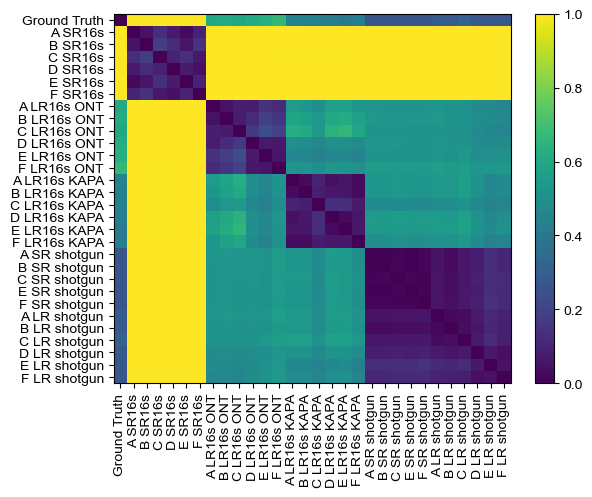

In [19]:
# BRAY-CURTIS DISTANCE (SPP)
spp_bc_dm = beta_diversity("braycurtis", countmatrix_spp, ids)
spp_bc_dm

In [20]:
spp_bc_dm[0]

array([0.        , 1.        , 1.        , 0.99649965, 1.        ,
       1.        , 1.        , 0.60318016, 0.61086109, 0.59617981,
       0.61506151, 0.62918146, 0.66376638, 0.43787189, 0.43637182,
       0.4339    , 0.4225    , 0.40894089, 0.42577129, 0.26416321,
       0.26252625, 0.26896345, 0.2633    , 0.26436322, 0.28856443,
       0.28126406, 0.30546527, 0.2739    , 0.27022702, 0.2709    ])

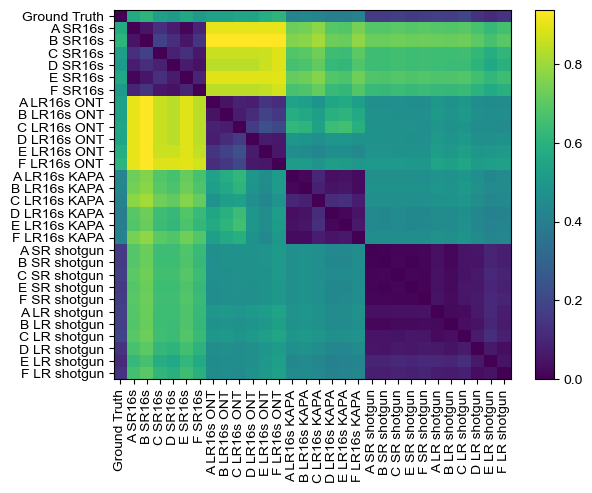

In [21]:
# BRAY-CURTIS DISTANCE (GENUS)
genus_bc_dm = beta_diversity("braycurtis", countmatrix_genus, ids)
genus_bc_dm

In [213]:
genus_bc_dm[0]

array([0.        , 0.56947847, 0.60488024, 0.52585259, 0.50587529,
       0.55945595, 0.50865087, 0.533     , 0.53707685, 0.5520776 ,
       0.54755476, 0.58217911, 0.60658033, 0.42254225, 0.4326    ,
       0.42034203, 0.39456973, 0.3992    , 0.41247062, 0.1702    ,
       0.1687    , 0.18045902, 0.16561656, 0.17251725, 0.1766    ,
       0.1707    , 0.19285964, 0.13885694, 0.11391139, 0.1321    ])

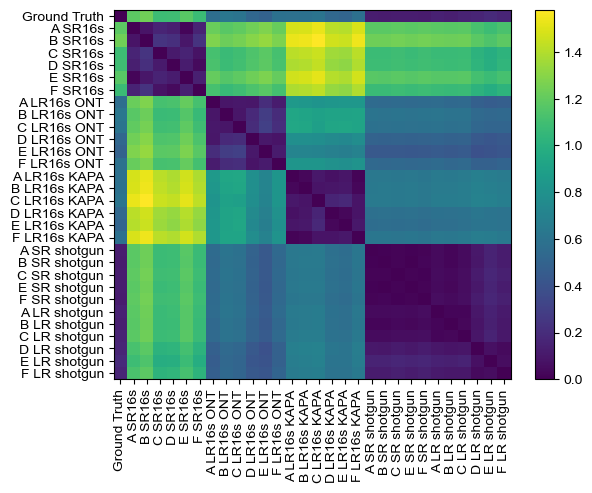

In [22]:
# UNWEIGHTED UNIFRAC (CONSIDERS PHLYOGENETIC DISTANCE) - SPP
spp_wu_dm = beta_diversity("weighted_unifrac", countmatrix_spp, ids, tree=myspptree,
                       otu_ids=myotu_ids_spp)
spp_wu_dm

In [23]:
spp_wu_dm[0]

array([0.        , 1.18229425, 1.23772874, 1.08081153, 1.08954943,
       1.17201375, 1.07698356, 0.56277011, 0.6260833 , 0.61005057,
       0.5233213 , 0.48996782, 0.58743116, 0.58181073, 0.59076935,
       0.60591259, 0.525562  , 0.51222364, 0.57482452, 0.12436092,
       0.12270882, 0.12614023, 0.12386118, 0.1202092 , 0.14610958,
       0.1344751 , 0.14988889, 0.16655269, 0.19128809, 0.16326183])

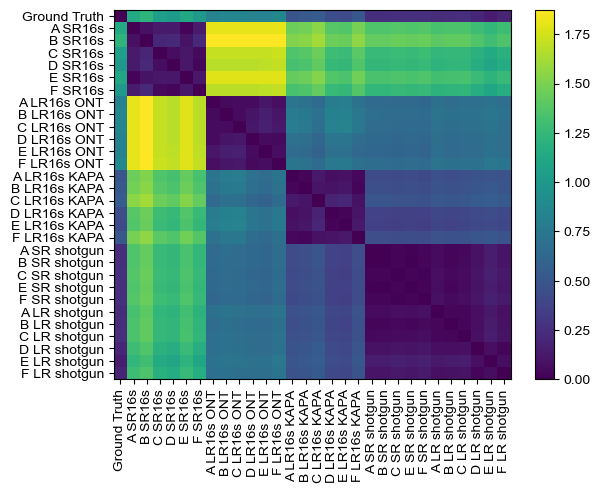

In [24]:
# UNWEIGHTED UNIFRAC (CONSIDERS PHLYOGENETIC DISTANCE) - GENUS
genus_wu_dm = beta_diversity("weighted_unifrac", countmatrix_genus, ids, tree=mygenustree,
                       otu_ids=myotu_ids_genus)
genus_wu_dm

In [25]:
genus_wu_dm[0]

array([0.        , 1.13893333, 1.20946061, 1.04579549, 1.01173333,
       1.11891189, 1.01721081, 0.83078965, 0.85754545, 0.85290303,
       0.82790097, 0.82878788, 0.8729697 , 0.49684968, 0.51467581,
       0.54874578, 0.43252727, 0.4226244 , 0.50609091, 0.24707879,
       0.2466974 , 0.26213333, 0.2493697 , 0.2611697 , 0.22778934,
       0.24027879, 0.25075152, 0.20147273, 0.15181818, 0.18982344])

### Compare beta diversity metrics

In [26]:
r, p_value, n = mantel(spp_wu_dm, spp_bc_dm)
print(r)
alpha = 0.05
print(f'p_value: {p_value} < alpha')

0.9626544465864788
p_value: 0.001 < alpha


/Users/issyburdon/miniforge3/envs/skbio/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.05288049907781917 and the largest is 6.961874173399693.
  warn(
/Users/issyburdon/miniforge3/envs/skbio/lib/python3.11/site-packages/skbio/stats/ordination/_ordination_results.py:285: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/Users/issyburdon/miniforge3/envs/skbio/lib/python3.11/site-packages/skbio/stats/ordination/_ordination_results.py:285: UserWarning: Tight layout not applied. The left and righ

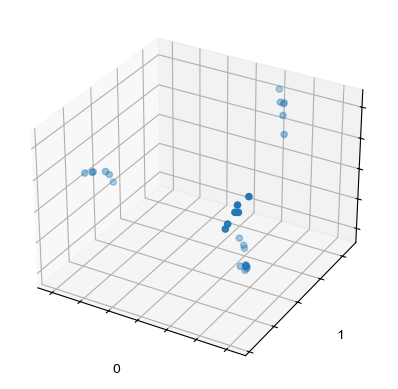

In [27]:
spp_wu_pc = pcoa(spp_wu_dm)
spp_wu_pc

### Alpha Diversity Visualisations

In [28]:
spp_shannon_matrix

[['Ground Truth', 1.8891591637540217],
 ['A SR16s', 0.799686152933352],
 ['B SR16s', 0.6601166119071632],
 ['C SR16s', 1.1195537930050048],
 ['D SR16s', 0.9386078787973382],
 ['E SR16s', 0.7576138130824341],
 ['F SR16s', 1.0028760391274654],
 ['A LR16s ONT', 1.2220835766570275],
 ['B LR16s ONT', 1.1570678085038126],
 ['C LR16s ONT', 1.2126882611100795],
 ['D LR16s ONT', 1.1940884293817473],
 ['E LR16s ONT', 1.1841896694985212],
 ['F LR16s ONT', 1.0979414232379],
 ['A LR16s KAPA', 1.4247339046671756],
 ['B LR16s KAPA', 1.4383465808373186],
 ['C LR16s KAPA', 1.5340948704829633],
 ['D LR16s KAPA', 1.390772442199916],
 ['E LR16s KAPA', 1.4013390953385128],
 ['F LR16s KAPA', 1.4492567942437662],
 ['A SR shotgun', 1.8966978918408186],
 ['B SR shotgun', 1.894550596725891],
 ['C SR shotgun', 1.8867767200508814],
 ['E SR shotgun', 1.8872045442723266],
 ['F SR shotgun', 1.8738471334096307],
 ['A LR shotgun', 1.943127434070306],
 ['B LR shotgun', 1.900654092102617],
 ['C LR shotgun', 1.9080062732

In [29]:
meta_data = ['Ground Truth', 'SR 16s', 'LR 16s (ONT)', 'LR 16s (KAPA)', 'SR shotgun', 'LR shotgun']
alpha_diversity_df = pd.DataFrame({'Sample': ids, 'Richness': spp_richness, 'Shannon': [x[1] for x in spp_shannon_matrix], 'Faith_PD': spp_adiv_faith_pd})
alpha_diversity_df.reset_index(drop=True, inplace=True)

for i in range(len(alpha_diversity_df)):
    if i == 0:
        alpha_diversity_df.at[i, 'Meta_Data'] = meta_data[0]
    elif i <= 6:
        alpha_diversity_df.at[i, 'Meta_Data'] = meta_data[1]
    elif i <= 12:
        alpha_diversity_df.at[i, 'Meta_Data'] = meta_data[2]
    elif i <= 18:
        alpha_diversity_df.at[i, 'Meta_Data'] = meta_data[3]
    elif i <= 23:
        alpha_diversity_df.at[i, 'Meta_Data'] = meta_data[4]
    else:
        alpha_diversity_df.at[i, 'Meta_Data'] = meta_data[5]

In [30]:
### FUNCTION TO PLOT ALPHA DIVERSITY SPECIES ###

def alpha_scatter(df, background_colour, plot_colour,
                  line_colour, font_colour, grid_colour):
    unique_categories = df["Meta_Data"].unique()

    # colours
    face_colour_list = ['#D7F1FF', '#C8E6C9', '#F0F4C3', '#FFD180', '#FFCCBC', '#F8BBD0']
    edge_colour_list = ['#1A237E', '#2E7D32', '#827717', '#FF6F00', '#D84315', '#C2185B']

    # Create a dictionary mapping each category to its corresponding color
    category_to_color = {category: (face_colour_list[i], edge_colour_list[i]) for i, category in enumerate(unique_categories)}
    face_colors = df["Meta_Data"].map(lambda x: category_to_color[x][0])
    edge_colors = df["Meta_Data"].map(lambda x: category_to_color[x][1])

    # Scatter plot with coloring by Meta_Data column
    plt.scatter(df["Shannon"], df["Faith_PD"], c=face_colors, edgecolors=edge_colors)

    # Labels
    plt.xlabel("Shannon index")
    plt.ylabel("Faith diversity")

    # Create a custom legend
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=face_colour_list[i], markeredgecolor=edge_colour_list[i], label=category) for i, category in enumerate(unique_categories)]
    plt.legend(handles=legend_handles, title="Seq. Method", loc="upper left", fontsize='small')

    # title and labels
    plt.suptitle('Comparison of Alpha Diversity Metrics', color=font_colour, fontsize=14, 
                 fontweight='bold', y=1)
    plt.title('by Sequencing Method - Species Level', color=font_colour, fontsize=14)
    plt.xlabel('Faith Diversity', color=font_colour, fontsize=10, fontweight='bold')
    plt.ylabel('Shannon Index', color=font_colour, fontsize=10, fontweight='bold')
    
    # set axis object
    ax = plt.gca() 

    # plt.xscale('log')
    ax.tick_params(axis='x', colors=line_colour)
    ax.tick_params(axis='y', colors=line_colour)

    # grid params
    ax.grid(color=grid_colour, linewidth=0.3)
    ax.set_facecolor(plot_colour)
    
    # figure params
    figure = plt.gcf()
    figure.set_facecolor(background_colour)
    plt.gcf().set_size_inches(8, 4)
    plt.gcf().patch.set_edgecolor(line_colour)

    plt.show()

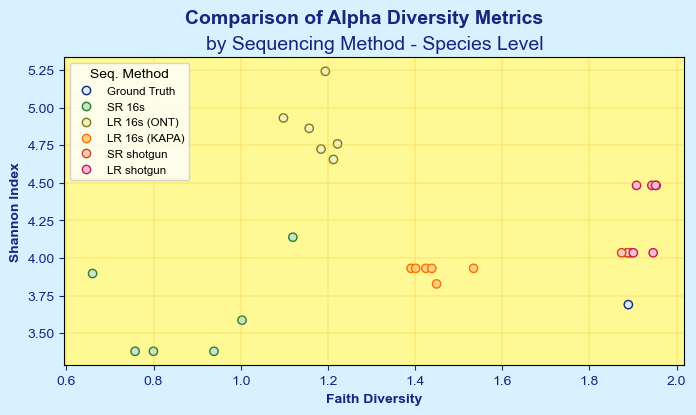

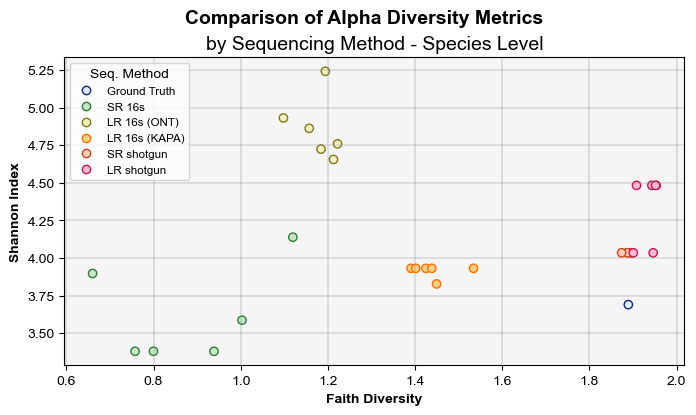

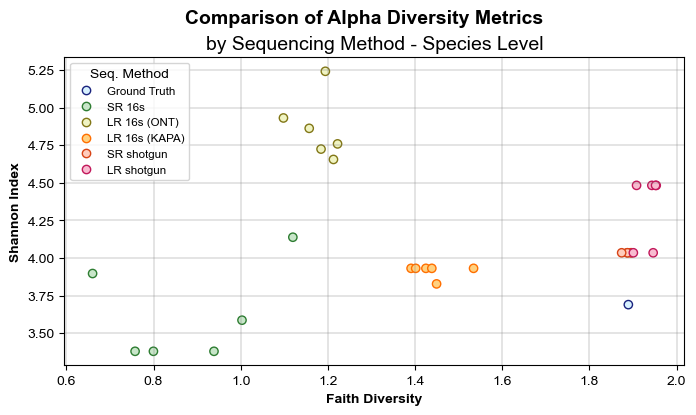

In [31]:
### PLOT ALPHA DIVERSITY SPECIES ###

# colours 1
background_colour = '#D7F1FF'
plot_colour = '#FEF995'
font_colour = '#1A237E'
line_colour = '#1A237E'
grid_colour = '#FBC02D'
alpha_scatter(alpha_diversity_df, background_colour, plot_colour,
                  line_colour, font_colour, grid_colour)

# colours 2
background_colour = 'none'
plot_colour = 'whitesmoke'
font_colour = 'black'
line_colour = 'black'
grid_colour = 'grey'
alpha_scatter(alpha_diversity_df, background_colour, plot_colour,
                  line_colour, font_colour, grid_colour)

# colours 3
background_colour = 'none'
plot_colour = 'none'
font_colour = 'black'
line_colour = 'black'
grid_colour = 'grey'
alpha_scatter(alpha_diversity_df, background_colour, plot_colour,
                  line_colour, font_colour, grid_colour)

In [57]:
def shannon_boxplot(data, background_colour, plot_colour, 
                    font_colour, line_colour, grid_colour):
    
    labels = ['Ground Truth', 'LR shotgun', 'SR shotgun', 'LR 16s (KAPA)', 'LR 16s (ONT)', 'SR 16s']
    
    grouped_data = data.groupby('Meta_Data')

    # List to store lists of Shannon diversities matched by metadata
    shannon_list = []

    for name, group in grouped_data:
        shannon_values = group['Shannon'].tolist()
        shannon_list.append(shannon_values)

    ordered_shannon_list = [shannon_list[0], shannon_list[3], shannon_list[5], 
                            shannon_list[1], shannon_list[2], shannon_list[4]]

    bplot = plt.boxplot(x=ordered_shannon_list, vert=True, 
                        patch_artist=True,
                        labels=labels)

    # Change the colour of the boxes (face colors)
    face_colour_list = ['#D7F1FF', '#C8E6C9', '#F0F4C3', '#FFD180', '#FFCCBC', '#F8BBD0']
    edge_colour_list = ['#1A237E', '#2E7D32', '#827717', '#FF6F00', '#D84315', '#C2185B']

    for i, box in enumerate(bplot['boxes']):
        box.set(color=edge_colour_list[i], linewidth=2)
        box.set(facecolor=face_colour_list[i])
        for component in ['whiskers', 'fliers', 'medians', 'caps']:
            lines = bplot[component]
            if component == 'fliers':
                for j, line in enumerate(lines):
                    if j < len(data['Meta_Data'].unique()):  # Ensure index does not go out of range
                        line.set(marker='o', markeredgecolor='grey', markerfacecolor='none', 
                                 color=edge_colour_list[i % len(edge_colour_list)], markersize=7, markeredgewidth=2)  # Match marker face color and edge color to box color
            elif component == 'medians':
                lines[i].set(color=edge_colour_list[i % len(edge_colour_list)], linewidth=2)  # Set median line color
            else:
                for line in lines[i*2:i*2 + 2]:
                    line.set(color=edge_colour_list[i % len(edge_colour_list)], linewidth=2)

    # title and labels
    plt.suptitle('Shannon Diversity Boxplot', color=font_colour, fontsize=14, 
                 fontweight='bold', y=0.98)
    plt.title('by Sequencing Method - Species Level', color=font_colour, fontsize=14)
    plt.ylabel('Shannon Diversity', color=font_colour, fontsize=10, fontweight='bold')
    plt.xlabel('Sequencing Method', color=font_colour, fontsize=10, fontweight='bold')

    # set axis object
    ax = plt.gca() 

    # plt.xscale('log')
    ax.tick_params(axis='x', colors=line_colour)
    ax.tick_params(axis='y', colors=line_colour)

    # grid params
    ax.grid(color=grid_colour, linewidth=0.3)
    ax.set_facecolor(plot_colour)
    
    # figure params
    figure = plt.gcf()
    figure.set_facecolor(background_colour)
    plt.gcf().set_size_inches(7, 5)
    plt.gcf().patch.set_edgecolor(line_colour)

    plt.show()

In [56]:
grouped_data = alpha_diversity_df.groupby('Meta_Data')

# List to store lists of Shannon diversities matched by metadata
shannon_list = []

for name, group in grouped_data:
    shannon_values = group['Shannon'].tolist()
    print(name)
    print(shannon_values)

Ground Truth
[1.8891591637540217]
LR 16s (KAPA)
[1.4247339046671756, 1.4383465808373186, 1.5340948704829633, 1.390772442199916, 1.4013390953385128, 1.4492567942437662]
LR 16s (ONT)
[1.2220835766570275, 1.1570678085038126, 1.2126882611100795, 1.1940884293817473, 1.1841896694985212, 1.0979414232379]
LR shotgun
[1.943127434070306, 1.900654092102617, 1.9080062732041603, 1.9531200130829693, 1.946097855970364, 1.9516387366489656]
SR 16s
[0.799686152933352, 0.6601166119071632, 1.1195537930050048, 0.9386078787973382, 0.7576138130824341, 1.0028760391274654]
SR shotgun
[1.8966978918408186, 1.894550596725891, 1.8867767200508814, 1.8872045442723266, 1.8738471334096307]


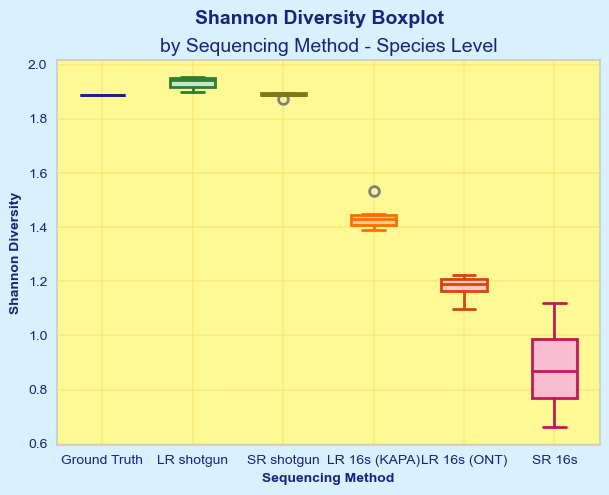

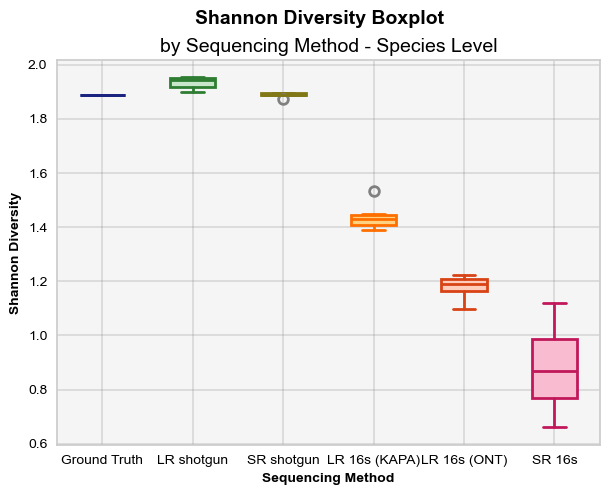

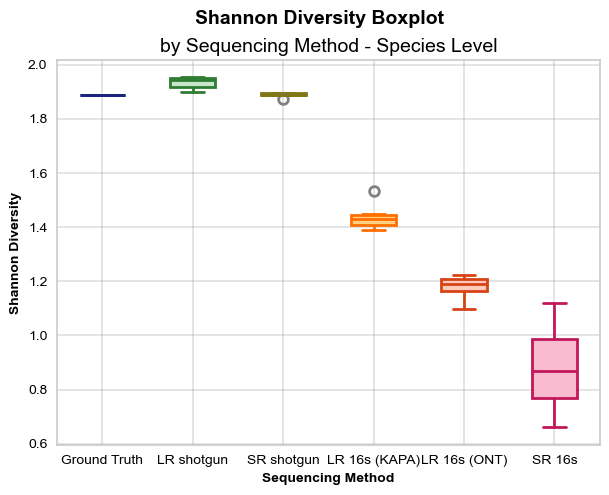

In [58]:
### PLOT SHANNON DIVERSITY ###

# colours 1
background_colour = '#D7F1FF'
plot_colour = '#FEF995'
font_colour = '#1A237E'
line_colour = '#1A237E'
grid_colour = '#FBC02D'
shannon_boxplot(alpha_diversity_df, background_colour, 
                plot_colour, font_colour, line_colour, grid_colour)

# colours 2
background_colour = 'none'
plot_colour = 'whitesmoke'
font_colour = 'black'
line_colour = 'black'
grid_colour = 'grey'
shannon_boxplot(alpha_diversity_df, background_colour, 
                plot_colour, font_colour, line_colour, grid_colour)

# colours 3
background_colour = 'none'
plot_colour = 'none'
font_colour = 'black'
line_colour = 'black'
grid_colour = 'grey'
shannon_boxplot(alpha_diversity_df, background_colour, 
                plot_colour, font_colour, line_colour, grid_colour)

In [59]:

def faith_boxplot(data, background_colour, plot_colour,
                  font_colour, line_colour, grid_colour):
    
    labels = ['Ground Truth', 'LR shotgun', 'SR shotgun', 'LR 16s (KAPA)', 'LR 16s (ONT)', 'SR 16s']
    
    grouped_data = data.groupby('Meta_Data')

    # List to store lists of Shannon diversities matched by metadata
    faith_list = []

    for name, group in grouped_data:
        faith_values = group['Faith_PD'].tolist()
        faith_list.append(faith_values)

    ordered_shannon_list = [faith_list[0], faith_list[3], faith_list[5], 
                            faith_list[1], faith_list[2], faith_list[4]]

    bplot = plt.boxplot(x=ordered_shannon_list, vert=True, 
                        patch_artist=True,
                        labels=labels)

    # Change the colour of the boxes (face colors)
    face_colour_list = ['#D7F1FF', '#C8E6C9', '#F0F4C3', '#FFD180', '#FFCCBC', '#F8BBD0']
    edge_colour_list = ['#1A237E', '#2E7D32', '#827717', '#FF6F00', '#D84315', '#C2185B']

    for i, box in enumerate(bplot['boxes']):
        box.set(color=edge_colour_list[i], linewidth=2)
        box.set(facecolor=face_colour_list[i])
        for component in ['whiskers', 'fliers', 'medians', 'caps']:
            lines = bplot[component]
            if component == 'fliers':
                for j, line in enumerate(lines):
                    if j < len(data['Meta_Data'].unique()):  # Ensure index does not go out of range
                        line.set(marker='o', markeredgecolor=line_colour, markerfacecolor='none', color=edge_colour_list[i % len(edge_colour_list)], markersize=7, markeredgewidth=2)  # Match marker face color and edge color to box color
            elif component == 'medians':
                lines[i].set(color=edge_colour_list[i % len(edge_colour_list)], linewidth=2)  # Set median line color
            else:
                for line in lines[i*2:i*2 + 2]:
                    line.set(color=edge_colour_list[i % len(edge_colour_list)], linewidth=2)

    # title and labels
    plt.suptitle('Faith Diversity Boxplot', color=font_colour, fontsize=14, 
                 fontweight='bold', y=0.98)
    plt.title('by Sequencing Method - Species Level', color=font_colour, fontsize=14)
    plt.ylabel('Faith Diversity', color=font_colour, fontsize=10, fontweight='bold')
    plt.xlabel('Sequencing Method', color=font_colour, fontsize=10, fontweight='bold')

    
    # set axis object
    ax = plt.gca() 

    # plt.xscale('log')
    ax.tick_params(axis='x', colors=line_colour)
    ax.tick_params(axis='y', colors=line_colour)

    # grid params
    ax.grid(color=grid_colour, linewidth=0.3)
    ax.set_facecolor(plot_colour)
    
    # figure params
    figure = plt.gcf()
    figure.set_facecolor(background_colour)
    plt.gcf().set_size_inches(7, 5)
    plt.gcf().patch.set_edgecolor(line_colour)

    plt.show()

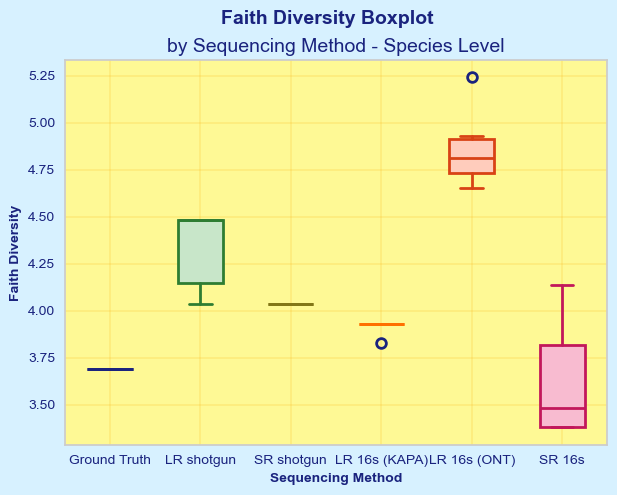

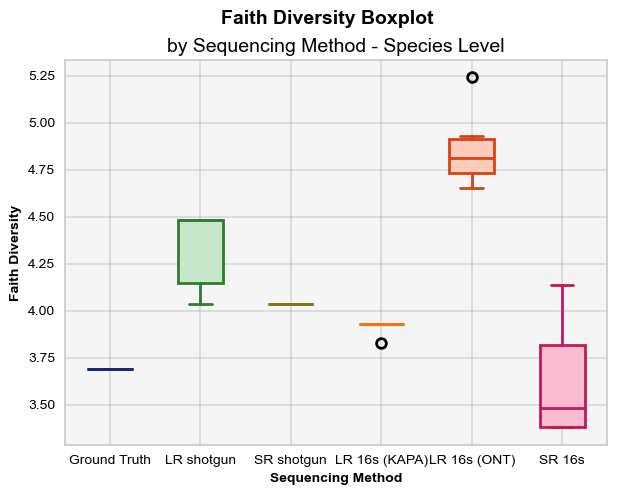

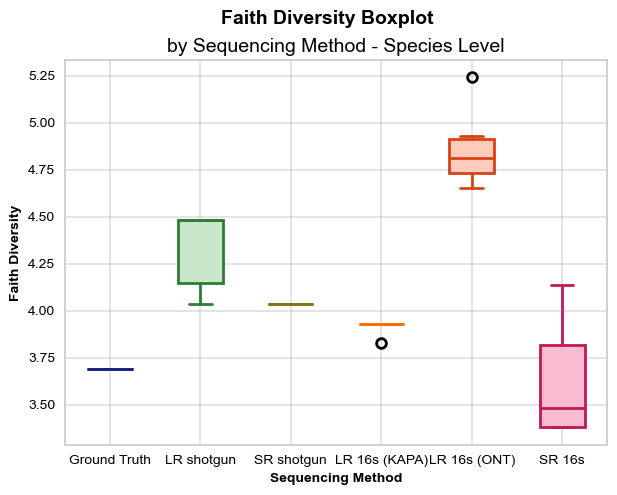

In [60]:

# colours 1
background_colour = '#D7F1FF'
plot_colour = '#FEF995'
font_colour = '#1A237E'
line_colour = '#1A237E'
grid_colour = '#FBC02D'
faith_boxplot(alpha_diversity_df, background_colour, 
                plot_colour, font_colour, line_colour, grid_colour)

# colours 2
background_colour = 'none'
plot_colour = 'whitesmoke'
font_colour = 'black'
line_colour = 'black'
grid_colour = 'grey'
faith_boxplot(alpha_diversity_df, background_colour, 
                plot_colour, font_colour, line_colour, grid_colour)

# colours 3
background_colour = 'none'
plot_colour = 'none'
font_colour = 'black'
line_colour = 'black'
grid_colour = 'grey'
faith_boxplot(alpha_diversity_df, background_colour, 
                plot_colour, font_colour, line_colour, grid_colour)

### Alpha Diversity Clustering

In [43]:
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from yellowbrick.cluster import KElbowVisualizer

In [44]:
cluster_data = pd.DataFrame()

cluster_data['Shannon'] = alpha_diversity_df["Shannon"]
cluster_data['Faith_PD'] = alpha_diversity_df["Faith_PD"]

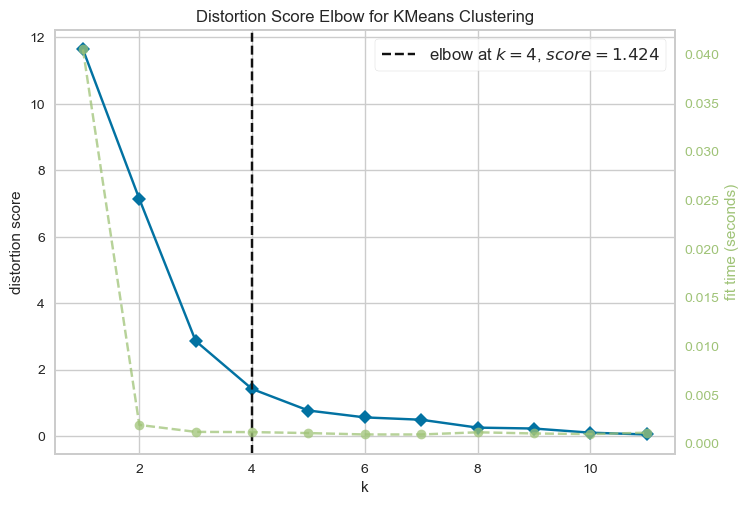

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
# elbow curve using yellow brick
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(cluster_data)        # Fit the data to the visualizer
visualizer.show()

In [46]:
# Kmeans algorithm
k_model = KMeans(n_clusters=4, random_state=0)
k_model.fit(cluster_data)
predictions = k_model.predict(cluster_data)

# Birch algorithm
birch_model = Birch(n_clusters=4)
birch_model.fit(cluster_data)
birch_predictions = birch_model.predict(cluster_data)

# Use the AgglomerativeClustering algorithm.
agglo_model = AgglomerativeClustering(n_clusters=4)
agglo_predictions = agglo_model.fit_predict(cluster_data)

# Make predictions dataframe
predictions_df = pd.DataFrame(cluster_data)
predictions_df['kmeans_labels'] = birch_predictions
predictions_df['birch_labels'] = birch_predictions
predictions_df['agglo_labels'] = agglo_predictions

/Users/issyburdon/miniforge3/envs/skbio/lib/python3.11/site-packages/sklearn/cluster/_birch.py:725: ConvergenceWarning: Number of subclusters found (3) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(


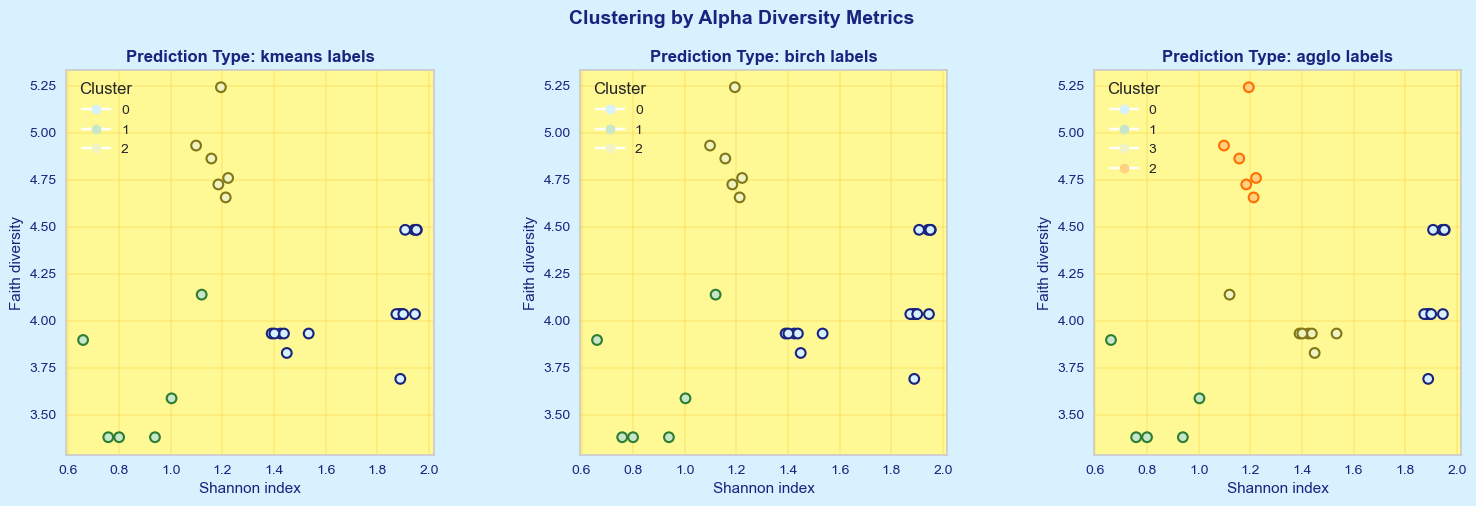

In [47]:
def cluster_scatter(df):

    prediction_types = ['kmeans_labels', 'birch_labels', 'agglo_labels']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create a figure with 3 subplots

    for i, ax in enumerate(axes.flat):

        prediction_type = prediction_types[i]

        clusters = df[prediction_type].unique()
        face_colour_list = ['#D7F1FF', '#C8E6C9', '#F0F4C3', '#FFD180', '#FFCCBC', '#F8BBD0']
        edge_colour_list = ['#1A237E', '#2E7D32', '#827717', '#FF6F00', '#D84315', '#C2185B']

        cluster_to_color = {cluster: (face_colour_list[i], edge_colour_list[i]) for i, cluster in enumerate(clusters)}
        face_colors = df[prediction_type].map(lambda x: cluster_to_color[x][0])
        edge_colors = df[prediction_type].map(lambda x: cluster_to_color[x][1])

        ax.scatter(df["Shannon"], df["Faith_PD"], c=face_colors, edgecolors=edge_colors, linewidths=1.5)
        ax.set_xlabel("Shannon index", color='#1A237E')
        ax.set_ylabel("Faith diversity", color='#1A237E')
        ax.set_title("Prediction Type: {}".format(prediction_type.replace('_', ' ')), color='#1A237E', fontweight='bold')
        ax.tick_params(axis='x', colors='#1A237E', color='#1A237E')
        ax.tick_params(axis='y', colors='#1A237E', color='#1A237E')
        ax.grid(color='#FBC02D', linewidth=0.3)
        ax.set_facecolor('#FEF995')

        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=face_colour_list[j], 
                                     markeredgecolor=edge_colour_list[j], label=cluster) for j, cluster in enumerate(clusters)]
        ax.legend(handles=legend_handles, title="Cluster", loc="upper left", fontsize='small')

    plt.suptitle('Clustering by Alpha Diversity Metrics', color='#1A237E', fontsize=14, fontweight='bold', y=1)
    plt.subplots_adjust(wspace=0.4)  # Adjust the space between subplots
    fig.set_facecolor('#D7F1FF')
    plt.show()

# Call the function with the DataFrame and different labels columns
cluster_scatter(predictions_df)  # For K-means
# cluster_scatter(predictions_df, 'birch_labels')  # For Birch
# cluster_scatter(predictions_df, 'agglo_labels')  # For Agglomerative
